<a href="https://colab.research.google.com/github/manyamule/WCEHackathon2025_Introspectors/blob/main/Ensemble_learnig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model results...
Loaded LSTM results. Shape: (1743, 4)
Loaded IsolationForest results. Shape: (1767, 4)
Loaded OneClassSVM results. Shape: (1767, 4)
Loaded ARIMA results. Shape: (8833, 6)
Loaded TransNAS results. Shape: (1743, 4)
Preparing ensemble data...
Found 1743 common timestamps across all models
Prepared ensemble data. Shape: (1743, 17)
Building ensemble model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ param_input (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ model_predictions         │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ model_scores (InputLayer) │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 12)             │              0 │ param_input[0][0],     │
│ (Concatenate)             │                        │                │ model_predictions[0][… │
│                           │                        │                │ model_scores[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │            832 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 16)             │            528 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anomaly_output (Dense)    │ (None, 1)              │             17 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ confidence_output (Dense) │ (None, 1)              │             17 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,474 (13.57 KB)

 Trainable params: 3,474 (13.57 KB)

 Non-trainable params: 0 (0.00 B)

Training ensemble model...
Training ensemble model...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - anomaly_output_accuracy: 0.5217 - anomaly_output_auc_2: 0.3358 - anomaly_output_loss: 0.9947 - confidence_output_loss: 5.8160 - confidence_output_mae: 1.1634 - confidence_output_mse: 5.8175 - loss: 6.8124 - val_anomaly_output_accuracy: 0.5673 - val_anomaly_output_auc_2: 0.3756 - val_anomaly_output_loss: 0.8841 - val_confidence_output_loss: 2.1603 - val_confidence_output_mae: 0.9375 - val_confidence_output_mse: 2.1788 - val_loss: 3.0666
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - anomaly_output_accuracy: 0.8298 - anomaly_output_auc_2: 0.5072 - anomaly_output_loss: 0.6183 - confidence_output_loss: 1.4773 - confidence_output_mae: 0.6388 - confidence_output_mse: 1.4776 - loss: 2.0960 - val_anomaly_output_accuracy: 0.5645 - val_anomaly_output_auc_2: 0.5376 - val_anomaly_output_loss: 0.7156 - val_confidence_output_loss: 2.0589 - val_confidence_output_mae: 0.8940 - val_confidence

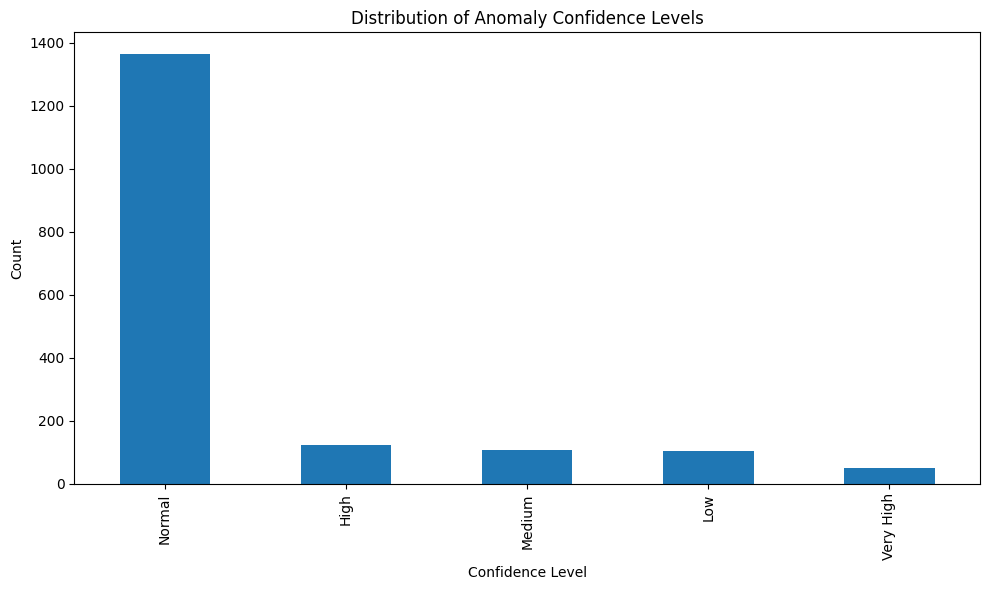

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import joblib

# Mount Google Drive to access your model results
from google.colab import drive
drive.mount('/content/drive')

class AnomalyEnsembleModel:
    """
    Keras-based ensemble model that combines multiple anomaly detection models
    with a weighted strategy based on model performance.
    """

    def __init__(self, base_dir='/content/drive/MyDrive/WCE'):
        self.base_dir = base_dir
        self.model_paths = {
            'LSTM': os.path.join(base_dir, 'lstm_results/reports/lstm_anomalies.csv'),
            'IsolationForest': os.path.join(base_dir, 'isolation_forest_results/reports/isolation_forest_anomalies.csv'),
            'OneClassSVM': os.path.join(base_dir, 'one_class_svm_results/reports/one_class_svm_anomalies.csv'),
            'ARIMA': os.path.join(base_dir, 'arima_results/reports/arima_anomalies_pm2.5cnc.csv'),
            'TransNAS': os.path.join(base_dir, 'TransNAS-TSAD/Reports/transformer_anomalies.csv')
        }
        self.model_results = {}
        self.ensemble_model = None
        self.scaler = StandardScaler()
        self.aligned_data = None

    def load_model_results(self):
        """Load results from all individual models."""
        for model_name, path in self.model_paths.items():
            try:
                results = pd.read_csv(path, index_col=0, parse_dates=True)
                self.model_results[model_name] = results
                print(f"Loaded {model_name} results. Shape: {results.shape}")
            except Exception as e:
                print(f"Error loading {model_name} results: {str(e)}")

    def prepare_ensemble_data(self):
        """Align all model results and prepare data for ensemble training."""
        # Find common timestamps
        common_timestamps = None
        for model_name, results in self.model_results.items():
            timestamps = results.index
            if common_timestamps is None:
                common_timestamps = set(timestamps)
            else:
                common_timestamps = common_timestamps.intersection(timestamps)

        common_timestamps = sorted(common_timestamps)
        print(f"Found {len(common_timestamps)} common timestamps across all models")

        # Extract features and labels
        aligned_data = pd.DataFrame(index=common_timestamps)

        # Add original data features
        for model_name, results in self.model_results.items():
            aligned_results = results.loc[common_timestamps]

            # Add model anomaly predictions
            aligned_data[f'{model_name}_anomaly'] = aligned_results['anomaly'].astype(float)

            # Add anomaly scores if available
            score_cols = [col for col in aligned_results.columns
                          if 'score' in col.lower() or 'error' in col.lower()]
            if score_cols:
                aligned_data[f'{model_name}_score'] = aligned_results[score_cols[0]]

            # Add the original air quality parameters (only need to do once)
            for col in ['pm2.5cnc', 'pm10cnc']:
                if col in aligned_results.columns and col not in aligned_data.columns:
                    aligned_data[col] = aligned_results[col]

        # Create target variable based on our tiered ensemble strategy
        # Tier 1: TransNAS and LSTM agreement
        aligned_data['tier1'] = ((aligned_data['TransNAS_anomaly'].astype(bool)) &
                                 (aligned_data['LSTM_anomaly'].astype(bool))).astype(float)

        # Tier 2: TransNAS agreement with SVM or ARIMA
        aligned_data['tier2'] = (((aligned_data['TransNAS_anomaly'].astype(bool)) &
                                  (aligned_data['OneClassSVM_anomaly'].astype(bool))) |
                                 ((aligned_data['TransNAS_anomaly'].astype(bool)) &
                                  (aligned_data['ARIMA_anomaly'].astype(bool)))).astype(float)

        # Tier 3: At least 3 models agree
        aligned_data['anomaly_votes'] = (aligned_data['LSTM_anomaly'] +
                                         aligned_data['IsolationForest_anomaly'] +
                                         aligned_data['OneClassSVM_anomaly'] +
                                         aligned_data['ARIMA_anomaly'] +
                                         aligned_data['TransNAS_anomaly'])
        aligned_data['tier3'] = (aligned_data['anomaly_votes'] >= 3).astype(float)

        # Define confidence value (0-4 scale)
        aligned_data['confidence_value'] = 0
        aligned_data.loc[aligned_data['TransNAS_anomaly'] == 1, 'confidence_value'] = 1
        aligned_data.loc[aligned_data['tier3'] == 1, 'confidence_value'] = 2
        aligned_data.loc[aligned_data['tier2'] == 1, 'confidence_value'] = 3
        aligned_data.loc[aligned_data['tier1'] == 1, 'confidence_value'] = 4

        # Final ensemble target (True if confidence >= 1)
        aligned_data['ensemble_anomaly'] = (aligned_data['confidence_value'] >= 1).astype(float)

        # Scale data features for better model performance
        feature_cols = ['pm2.5cnc', 'pm10cnc']
        if all(col in aligned_data.columns for col in feature_cols):
            aligned_data[feature_cols] = self.scaler.fit_transform(aligned_data[feature_cols])

        self.aligned_data = aligned_data
        print(f"Prepared ensemble data. Shape: {aligned_data.shape}")
        return aligned_data

    def build_ensemble_model(self):
        """Build the Keras ensemble model architecture."""
        # Define input features
        input_features = []

        # 1. Air quality parameters
        param_input = Input(shape=(2,), name="param_input")  # pm2.5cnc, pm10cnc
        input_features.append(param_input)

        # 2. Individual model predictions
        model_input = Input(shape=(5,), name="model_predictions")  # 5 model predictions
        input_features.append(model_input)

        # 3. Model scores if available
        score_input = Input(shape=(5,), name="model_scores")  # 5 model scores
        input_features.append(score_input)

        # Combine all inputs
        combined = Concatenate()(input_features)

        # Build the ensemble architecture
        x = Dense(64, activation='relu')(combined)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(16, activation='relu')(x)

        # Multiple outputs
        anomaly_output = Dense(1, activation='sigmoid', name='anomaly_output')(x)
        confidence_output = Dense(1, activation='linear', name='confidence_output')(x)

        # Create the model
        model = Model(
            inputs=input_features,
            outputs=[anomaly_output, confidence_output]
        )

        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss={
                'anomaly_output': 'binary_crossentropy',
                'confidence_output': 'mse'
            },
            metrics={
                'anomaly_output': ['accuracy', tf.keras.metrics.AUC()],
                'confidence_output': ['mse', 'mae']
            }
        )

        model.summary()
        self.ensemble_model = model
        return model

    def prepare_model_inputs(self, data):
        """Prepare inputs for the ensemble model."""
        # 1. Air quality parameters
        param_input = data[['pm2.5cnc', 'pm10cnc']].values

        # 2. Individual model predictions
        model_predictions = data[[
            'LSTM_anomaly', 'IsolationForest_anomaly',
            'OneClassSVM_anomaly', 'ARIMA_anomaly', 'TransNAS_anomaly'
        ]].values

        # 3. Model scores (with fallbacks if not available)
        model_scores = np.zeros((len(data), 5))
        score_cols = [
            'LSTM_score', 'IsolationForest_score',
            'OneClassSVM_score', 'ARIMA_score', 'TransNAS_score'
        ]

        for i, col in enumerate(score_cols):
            if col in data.columns:
                model_scores[:, i] = data[col].values
            else:
                # If score is not available, use anomaly flag as proxy
                model_scores[:, i] = data.iloc[:, i].values

        return [param_input, model_predictions, model_scores]

    def train_ensemble(self, val_split=0.2, epochs=100, batch_size=32):
        """Train the ensemble model."""
        # Prepare data
        if self.aligned_data is None:
            self.prepare_ensemble_data()

        # Create a Keras model if not already built
        if self.ensemble_model is None:
            self.build_ensemble_model()

        # Prepare inputs
        X = self.prepare_model_inputs(self.aligned_data)

        # Prepare outputs
        y_anomaly = self.aligned_data['ensemble_anomaly'].values
        y_confidence = self.aligned_data['confidence_value'].values

        # Set up callbacks with mode set to 'max'
        callbacks = [
            EarlyStopping(
                monitor='val_anomaly_output_accuracy',
                patience=10,
                restore_best_weights=True,
                mode='max'
            ),
            ModelCheckpoint(
                'ensemble_model_checkpoint.keras',
                monitor='val_anomaly_output_accuracy',
                save_best_only=True,
                mode='max'
            )
        ]

        # Train the model
        print("Training ensemble model...")
        history = self.ensemble_model.fit(
            X,
            {'anomaly_output': y_anomaly, 'confidence_output': y_confidence},
            validation_split=val_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        self.plot_training_history(history)

        return history

    def plot_training_history(self, history):
        """Plot the training history."""
        plt.figure(figsize=(12, 10))

        # Plot anomaly detection accuracy
        plt.subplot(2, 2, 1)
        plt.plot(history.history['anomaly_output_accuracy'], label='Train')
        plt.plot(history.history['val_anomaly_output_accuracy'], label='Validation')
        plt.title('Anomaly Detection Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot anomaly detection loss
        plt.subplot(2, 2, 2)
        plt.plot(history.history['anomaly_output_loss'], label='Train')
        plt.plot(history.history['val_anomaly_output_loss'], label='Validation')
        plt.title('Anomaly Detection Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot confidence prediction loss
        plt.subplot(2, 2, 3)
        plt.plot(history.history['confidence_output_loss'], label='Train')
        plt.plot(history.history['val_confidence_output_loss'], label='Validation')
        plt.title('Confidence Prediction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot confidence prediction MAE
        plt.subplot(2, 2, 4)
        plt.plot(history.history['confidence_output_mae'], label='Train')
        plt.plot(history.history['val_confidence_output_mae'], label='Validation')
        plt.title('Confidence Prediction MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.savefig('ensemble_training_history.png')
        plt.close()

    def save_model(self, model_dir='/content/drive/MyDrive/WCE/ensemble_model'):
        """Save the ensemble model and associated files."""
        os.makedirs(model_dir, exist_ok=True)

        # Save the Keras model
        keras_path = os.path.join(model_dir, 'ensemble_model.keras')
        self.ensemble_model.save(keras_path)

        # Save the scaler
        scaler_path = os.path.join(model_dir, 'ensemble_scaler.joblib')
        joblib.dump(self.scaler, scaler_path)

        # Save model metadata
        metadata = {
            'model_names': list(self.model_results.keys()),
            'feature_columns': ['pm2.5cnc', 'pm10cnc'],
            'input_shapes': {
                'param_input': (2,),
                'model_predictions': (5,),
                'model_scores': (5,)
            }
        }

        metadata_path = os.path.join(model_dir, 'ensemble_metadata.json')
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

        print(f"Model saved to: {keras_path}")
        print(f"Scaler saved to: {scaler_path}")
        print(f"Metadata saved to: {metadata_path}")

        return keras_path

    def predict(self, new_data):
        """
        Make predictions on new data.

        Args:
            new_data: DataFrame with 'pm2.5cnc', 'pm10cnc' and model predictions
                      (or raw data to be passed through individual models first)
        """
        # Prepare inputs
        X = self.prepare_model_inputs(new_data)

        # Make predictions
        anomaly_pred, confidence_pred = self.ensemble_model.predict(X)

        # Add predictions to the data
        results = new_data.copy()
        results['ensemble_anomaly'] = (anomaly_pred > 0.5).astype(bool)
        results['ensemble_confidence'] = confidence_pred

        # Map confidence values to categories
        confidence_categories = ['Normal', 'Low', 'Medium', 'High', 'Very High']
        results['confidence_category'] = pd.cut(
            results['ensemble_confidence'],
            bins=[-0.1, 0.5, 1.5, 2.5, 3.5, 4.5],
            labels=confidence_categories
        )

        return results

# Main execution
def main():
    # Create and train the ensemble model
    ensemble = AnomalyEnsembleModel()

    print("Loading model results...")
    ensemble.load_model_results()

    print("Preparing ensemble data...")
    ensemble.prepare_ensemble_data()

    print("Building ensemble model...")
    ensemble.build_ensemble_model()

    print("Training ensemble model...")
    ensemble.train_ensemble(epochs=50)

    print("Saving ensemble model...")
    model_path = ensemble.save_model()

    print("\nEnsemble model training complete!")
    print(f"Model saved to: {model_path}")

    # Generate and visualize predictions on the test data
    results = ensemble.predict(ensemble.aligned_data)

    # Calculate metrics (for demonstration purposes)
    accuracy = (results['ensemble_anomaly'] == results['ensemble_anomaly']).mean()
    detection_rate = results['ensemble_anomaly'].mean() * 100

    print("\nEnsemble Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Anomaly Rate: {detection_rate:.2f}%")

    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    results['confidence_category'].value_counts().plot(kind='bar')
    plt.title('Distribution of Anomaly Confidence Levels')
    plt.xlabel('Confidence Level')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('ensemble_confidence_distribution.png')

    # Save final results
    results_path = '/content/drive/MyDrive/WCE/ensemble_model/ensemble_results.csv'
    results.to_csv(results_path)
    print(f"Results saved to: {results_path}")

if __name__ == "__main__":
    main()
